# Project: Time series predictor with zero prescriptor ESP project
Description: Similar setup to Covid NPI project  
12/18/25: switch to package preprocessors

In [1]:
# import packages
import numpy as np
import pandas as pd
import torch
from typing import List, Dict, Any, Optional, Tuple, Sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# set working directory so we can load data correctly (all functions at this point are not put into modules yet)
import os
os.chdir('..')
os.getcwd()

'/Users/964505/CT/ct_research'

## Config

In [3]:
# ===================== CONFIG =====================
CONFIG = {
    "time": {
        "granularity": "week",
        "week_freq": "W-MON",
        "lookback_weeks": 12,
        "lookahead_weeks": 6,
        "agg": "mean",
        "missing_code": "00",
    },
    "features": {
        # pair-encoding is always used (present, 1-x)
        "covariates": [
            "week_index",
            "weeks_since_last_active",
            "n_sessions_week",
            "n_domains_week",
            "week_of_year",
        ]
    },
    "model": {
        "d_hidden": 128,
        "enc_layers": 1,
        "trunk_hidden": 128,
        "dropout": 0.10,
        "user_embed_dim": 32,
        "lowrank_r": 0,
    },
    "train": {
        "batch_size": 128,
        "epochs": 6,
        "lr": 2e-3,
        "weight_decay": 1e-4,
        "grad_clip": 1.0,
        "drop_no_target": True,
        "val_frac": 0.15,
        "train_frac": 0.70,
        "seed": 42,
    },
    "targets": {
        "outcome": "global",
    }
}
# ==============================================================

## General Helper Functions

In [4]:
def global_score(y_vec: np.ndarray, mask_vec: Optional[np.ndarray] = None) -> float:
    """
    y_vec: (K,) per-domain scores in [0,1]
    mask_vec: (K,) optional 1/0 mask of which domains are observed
    """
    if mask_vec is None:
        return float(np.mean(y_vec))
    m = np.asarray(mask_vec, dtype=float)
    s = m.sum()
    return 0.0 if s <= 1e-8 else float((y_vec * m).sum() / s)

In [5]:
def advance_weekly_covariates(last_x: np.ndarray) -> np.ndarray:
    """
    last_x: (D_x,) ordered as [week_index, weeks_since_last_active, n_sessions_week, n_domains_week, week_of_year]
    MVP policy: keep volume/breadth fixed; increment week_index + week_of_year; update gap accordingly.
    """
    week_index, gap, nsess, ndoms, week_of_year = last_x.tolist()
    week_index = float(week_index) + 1.0
    week_of_year = int(week_of_year) + 1
    if week_of_year > 53: week_of_year = 1
    gap = 0.0 if nsess > 0 else float(gap) + 1.0
    return np.array([week_index, gap, nsess, ndoms, float(week_of_year)], dtype=np.float32)

In [6]:
@dataclass
class RunConfig:
    window: int = 32
    horizon: int = 1
    outcome: str = "global"     # or "per_domain"
    lookahead_days: int = 6 * 7
    seed: int = 42

In [7]:
def get_users_with_min_viable_weeks(
    M_target: np.ndarray,
    meta: dict,
    min_weeks: int = 4,
    verbose: bool = True,
):
    """
    Return a list of user indices who have at least `min_weeks` viable weeks.
    
    A 'viable week' is defined as a week with at least one observed domain score.
    
    Parameters
    ----------
    M_target : np.ndarray
        Array of shape [U, T_max, K], mask of observed scores.
    meta : dict
        Metadata dictionary from encoder containing "weeks_per_user".
    min_weeks : int
        Minimum number of viable weeks required.
    verbose : bool
        Whether to print summary information.

    Returns
    -------
    List[int]
        User indices that satisfy the requirement.
    """
    U, T_max, K = M_target.shape
    viable_users = []
    viable_counts = []

    for u in range(U):
        T_u = len(meta["weeks_per_user"][u])
        M_u = M_target[u, :T_u]             # slice valid weeks only
        weekly_obs = (M_u.sum(axis=1) > 0)  # boolean: domain observed?
        n_viable = weekly_obs.sum()

        if n_viable >= min_weeks:
            viable_users.append(u)
            viable_counts.append(n_viable)

    if verbose:
        print(f"Users meeting >= {min_weeks} viable weeks: {len(viable_users)} / {U}")
        if len(viable_users) > 0:
            print(f"  Min viable = {min(viable_counts)}, Max viable = {max(viable_counts)}")
            print(f"  Median viable = {np.median(viable_counts):.1f}")
        else:
            print("  No users meet the criterion.")

    return viable_users

In [8]:
def get_user_indices_from_passing_users(meta, passing_users: set[int]) -> list[int]:
    """
    Given meta['users'] and a set of patient_ids (passing_users),
    return user indices that correspond to those patients.
    """
    idxs = [
        u_idx
        for u_idx, pid in enumerate(meta["users"])
        if pid in passing_users
    ]
    return idxs

## Load data

In [9]:
raw_data_df = pd.read_csv('data/raw/predictor_data_20250529.csv')
raw_data_df.head()

/var/folders/sq/wczx8z_50yn5szt1q9b333fr0000gp/T/ipykernel_51943/3211444471.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_df = pd.read_csv('data/raw/predictor_data_20250529.csv')


,id,patient_id,start_time,task_type_id,task_level,domain_ids,domain_scores
0,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
1,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
2,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
3,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"
4,11018577,2171,2018-04-13 17:37:55,4,1,"6,10","0.2950,0.8140"


In [10]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80506846 entries, 0 to 80506845
Data columns (total 7 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   patient_id     int64 
 2   start_time     object
 3   task_type_id   int64 
 4   task_level     int64 
 5   domain_ids     object
 6   domain_scores  object
dtypes: int64(4), object(3)
memory usage: 4.2+ GB


## Data preprocessing

In [11]:
from ct.data.consolidating import HistoryEncoder
from ct.viz.data import plot_random_patient_domain_avg

Preprocess data

In [12]:
encoder = HistoryEncoder(raw_data_df)
weekly_df = encoder.transform()

In [13]:
weekly_df.head()

domain_1_freq  domain_2_freq  domain_3_freq  \
patient_id week_number                                                
2171       0                        5              0              0   
           1                        0              0              0   
           2                        5              0              0   
           3                       10              0              0   
           4                       20              0              0   

                        domain_4_freq  domain_5_freq  domain_6_freq  \
patient_id week_number                                                
2171       0                        5              5              5   
           1                        0              0              0   
           2                        5              5              5   
           3                       10             10             10   
           4                       20             20             20   

                        domain_7_freq  domain_8_freq  domain_9_freq  \
patient_id week_number                                                
2171       0                        5              0              5   
           1                        0              0              0   
           2                        5              0              5   
           3                       10              0             10   
           4                       20              0             20   

                        domain_10_freq  ...  domain_5_inv  domain_6_inv  \
patient_id week_number                  ...                               
2171       0                         0  ...        0.7000         0.674   
           1                         0  ...        0.7000         0.674   
           2                         5  ...        0.7100         0.705   
           3                        10  ...        0.7250         0.737   
           4                        20  ...        0.7475         0.721   

                        domain_7_inv  domain_8_inv domain_9_inv  \
patient_id week_number                                            
2171       0                   0.790           0.0        0.370   
           1                   0.790           0.0        0.370   
           2                   0.820           0.0        0.460   
           3                   0.850           0.0        0.550   
           4                   0.835           0.0        0.505   

                        domain_10_inv  domain_11_inv  domain_12_inv  \
patient_id week_number                                                
2171       0                    0.000            0.0        0.00000   
           1                    0.000            0.0        0.00000   
           2                    0.379            0.0        0.48600   
           3                    0.379            0.0        0.47800   
           4                    0.232            0.0        0.46575   

                        domain_13_inv  domain_14_inv  
patient_id week_number                                
2171       0                    0.000            0.0  
           1                    0.000            0.0  
           2                    0.206            0.0  
           3                    0.224            0.0  
           4                    0.242            0.0  

[5 rows x 43 columns]

In [16]:
weekly_df.describe()

,domain_1_freq,domain_2_freq,domain_3_freq,domain_4_freq,domain_5_freq,domain_6_freq,domain_7_freq,domain_8_freq,domain_9_freq,domain_10_freq,...,domain_5_inv,domain_6_inv,domain_7_inv,domain_8_inv,domain_9_inv,domain_10_inv,domain_11_inv,domain_12_inv,domain_13_inv,domain_14_inv
count,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,...,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000,656755.000000
mean,16.013842,7.446415,11.043027,15.313006,19.114266,10.678032,5.505102,2.965343,8.518805,23.710839,...,0.655286,0.381779,0.228614,0.189140,0.398550,0.399089,0.118117,0.534350,0.363577,0.209011
std,66.437980,35.379972,46.786699,51.349464,64.319447,53.032810,32.197931,20.929224,35.986673,83.935611,...,0.317380,0.354823,0.321833,0.314508,0.363505,0.278469,0.227269,0.298551,0.271753,0.271464
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.516000,0.000000,0.000000,0.000000,0.000000,0.161000,0.000000,0.364000,0.108000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.764500,0.301667,0.000000,0.000000,0.390000,0.423000,0.000000,0.622000,0.364000,0.027000
75%,8.000000,0.000000,3.000000,10.000000,14.000000,0.000000,0.000000,0.000000,0.000000,15.000000,...,0.903000,0.720000,0.500000,0.283200,0.750000,0.600000,0.160000,0.750000,0.569667,0.333000
max,4152.000000,4080.000000,5500.000000,3720.000000,6760.000000,6912.000000,5016.000000,2328.000000,4428.000000,6744.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Visualize user trajectory

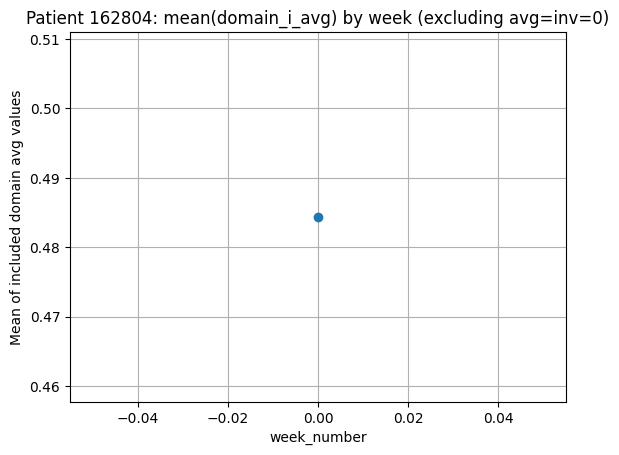

In [14]:
pid, aggregate_weekly_df = plot_random_patient_domain_avg(weekly_df, seed=42)

In [15]:
print(f"Plotted patient_id: {pid}")

Plotted patient_id: 162804


Filtering

In [17]:
from ct.data.filtering import filter_users_by_usage

In [18]:
## filter requirements

min_sessions_per_week = 1
min_weeks = 12
require_consecutive = True

In [19]:
filtered_weekly_df = filter_users_by_usage(
    weekly_df,
    min_sessions_per_week=min_sessions_per_week,
    min_weeks=min_weeks,
    require_consecutive=require_consecutive,
)

print(filtered_weekly_df.reset_index())

        patient_id  week_number  domain_1_freq  domain_2_freq  domain_3_freq  \
0             2171            0              5              0              0   
1             2171            1              0              0              0   
2             2171            2              5              0              0   
3             2171            3             10              0              0   
4             2171            4             20              0              0   
...            ...          ...            ...            ...            ...   
329016      568669           34             36             24             12   
329017      568669           35             40             16             16   
329018      568669           36             12              4              4   
329019      568669           37              0              0              0   
329020      568669           38             12              4              4   

        domain_4_freq  domain_5_freq  d

## Data encoding: turn into model input

In [ ]:
class PairEncodedWindowDatasetWeek(Dataset):
    def __init__(
        self,
        config: Dict[str, Any],
        E_pairs: np.ndarray,     # [U, T, K, 2]
        X_week: np.ndarray,      # [U, T, D_x]
        Y: np.ndarray,           # [U, T, K]
        M_target: np.ndarray,    # [U, T, K]
        meta: Dict[str, Any],
        actions: Optional[np.ndarray] = None,   # [U, T, Da] (optional)
        statics: Optional[np.ndarray] = None,   # [U, Ds]   (optional)
        user_time_slice: Optional[Dict[int, Tuple[int, int]]] = None,
        drop_no_target: Optional[bool] = None,
    ):
        super().__init__()
        self.cfg = config
        W = config["time"]["lookback_weeks"]
        self.window = W
        self.horizon = 1

        assert E_pairs.ndim == 4 and E_pairs.shape[-1] == 2
        U, T, K, _ = E_pairs.shape
        assert X_week.shape[:2] == (U, T)
        assert Y.shape == M_target.shape == (U, T, K)

        self.U, self.T, self.K = U, T, K
        self.meta = meta

        self.Dx = X_week.shape[2]
        self.Dp = 2 * K
        self.E_flat = E_pairs.reshape(U, T, self.Dp).astype(np.float32)
        self.X_week = X_week.astype(np.float32)

        pres = E_pairs[..., 0].astype(np.float32)
        invv = E_pairs[..., 1].astype(np.float32)
        self.Y_recon = pres * (1.0 - invv)   # [U,T,K]

        self.Y = Y.astype(np.float32)
        self.M = M_target.astype(np.float32)

        self.actions = actions.astype(np.float32) if actions is not None else None
        self.statics = statics.astype(np.float32) if statics is not None else None
        self.Da = 0 if self.actions is None else self.actions.shape[2]
        self.Ds = 0 if self.statics is None else self.statics.shape[1]

        # Build anchor indices
        self.indices: List[Tuple[int, int]] = []
        weeks_per_user: List[pd.DatetimeIndex] = meta.get("weeks_per_user", [pd.DatetimeIndex([]) for _ in range(U)])

        drop_no_target = self.cfg["train"]["drop_no_target"] if drop_no_target is None else drop_no_target
        for u in range(U):
            T_u = len(weeks_per_user[u])
            if T_u == 0: continue
            lo, hi = (0, T_u) if user_time_slice is None else user_time_slice.get(u, (0, T_u))
            lo = max(lo, self.window)
            hi = min(hi, T_u - self.horizon)
            for t in range(lo, hi):
                if drop_no_target and self.M[u, t, :].sum() < 1.0:
                    continue
                self.indices.append((u, t))

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        u, t = self.indices[idx]
        t0, t1 = t - self.window, t

        y_hist = self.Y_recon[u, t0:t1, :]                                  # [W,K]
        x_hist = np.concatenate([self.E_flat[u, t0:t1, :], self.X_week[u, t0:t1, :]], axis=-1)  # [W, 2K+D_x]

        a_now = self.actions[u, t, :] if self.actions is not None else np.zeros((0,), dtype=np.float32)
        s_static = self.statics[u, :]   if self.statics is not None else np.zeros((0,), dtype=np.float32)

        y_next = np.nan_to_num(self.Y[u, t, :].copy(), nan=0.0)             # [K]
        m_next = self.M[u, t, :].copy()

        return {
            "y_hist": torch.from_numpy(y_hist),
            "x_hist": torch.from_numpy(x_hist),
            "a_now": torch.from_numpy(a_now),
            "s_static": torch.from_numpy(s_static),
            "user_idx": torch.tensor(u, dtype=torch.long),
            "y_next": torch.from_numpy(y_next),
            "m_next": torch.from_numpy(m_next),
        }

    @property
    def dims(self) -> Dict[str, int]:
        return {
            "U": self.U,
            "K": self.K,
            "Dx_total": self.Dp + self.Dx,
            "Da": self.Da,
            "Ds": self.Ds,
            "W": self.window,
        }


def build_time_slices_weekly(meta: Dict[str, Any], config: Dict[str, Any]) -> Dict[int, Dict[str, Tuple[int, int]]]:
    train_frac = config["train"]["train_frac"]
    val_frac = config["train"]["val_frac"]
    slices: Dict[int, Dict[str, Tuple[int, int]]] = {}
    for u, weeks in enumerate(meta["weeks_per_user"]):
        T_u = len(weeks)
        if T_u == 0:
            slices[u] = {"train": (0, 0), "val": (0, 0), "test": (0, 0)}
            continue
        i1 = int(np.floor(train_frac * T_u))
        i2 = int(np.floor((train_frac + val_frac) * T_u))
        slices[u] = {"train": (0, i1), "val": (i1, i2), "test": (i2, T_u)}
    return slices


def make_weekly_dataloaders(config: Dict[str, Any],
                            E_pairs: np.ndarray, X_week: np.ndarray, Y: np.ndarray, M_target: np.ndarray, meta: Dict[str, Any],
                            actions: Optional[np.ndarray] = None, statics: Optional[np.ndarray] = None):
    slices = build_time_slices_weekly(meta, config)
    ds_train = PairEncodedWindowDatasetWeek(config, E_pairs, X_week, Y, M_target, meta,
                                            actions=actions, statics=statics,
                                            user_time_slice={u: s["train"] for u, s in slices.items()})
    ds_val   = PairEncodedWindowDatasetWeek(config, E_pairs, X_week, Y, M_target, meta,
                                            actions=actions, statics=statics,
                                            user_time_slice={u: s["val"] for u, s in slices.items()})
    ds_test  = PairEncodedWindowDatasetWeek(config, E_pairs, X_week, Y, M_target, meta,
                                            actions=actions, statics=statics,
                                            user_time_slice={u: s["test"] for u, s in slices.items()})
    bs = config["train"]["batch_size"]
    dl_train = DataLoader(ds_train, batch_size=bs, shuffle=True)
    dl_val   = DataLoader(ds_val,   batch_size=bs, shuffle=False)
    dl_test  = DataLoader(ds_test,  batch_size=bs, shuffle=False)
    return ds_train, ds_val, ds_test, dl_train, dl_val, dl_test

build cao map for later

In [ ]:
def build_cao_mapping_from_weekly_encoding(config: Dict[str, Any], meta: Dict[str, Any]) -> Tuple[Dict[str, List[str]], int, List[str]]:
    W = config["time"]["lookback_weeks"]
    domains: List[int] = list(meta["domains"])
    K = len(domains)
    covs: List[str] = list(meta.get("x_week_feature_names", []))

    # Context (scores) with weekly lags 1..W
    context_scores = [f"score_domain_{d}_lag_{k}" for k in range(1, W + 1) for d in domains]
    # Optional extras (pair + covariates), if you want to name them for inspection
    context_pair_presence = [f"present_domain_{d}_lag_{k}" for k in range(1, W + 1) for d in domains]
    context_pair_inv1m    = [f"inv1m_domain_{d}_lag_{k}"  for k in range(1, W + 1) for d in domains]
    context_covariates    = [f"{feat}_lag_{k}" for k in range(1, W + 1) for feat in covs]

    # Final context (you can include only scores if you prefer)
    context = list(context_scores) + context_pair_presence + context_pair_inv1m + context_covariates

    # Actions: one per domain (binary selection), lag_0 convention
    action_names = [f"action_domain_{d}_lag_0" for d in domains]
    Da = len(action_names)  # == K
    print("Da in build_cao_mapping_from_weekly_encoding:", Da)

    # Outcome: global or per-domain
    if config["targets"]["outcome"] == "global":
        outcome = ["global_score_next_week"]
    else:
        outcome = [f"score_domain_{d}_next_week" for d in domains]

    cao_mapping = {"context": context, "actions": action_names, "outcome": outcome}
    return cao_mapping, Da, action_names

Encode data

In [ ]:
# Build time-blocked slices per user (on weeks)
slices = build_time_slices_weekly(meta, CONFIG)

# Lookback window in *weeks* from CONFIG
W = CONFIG["time"]["lookback_weeks"]

# Optional: if you have actions/statics arrays aligned to [U, T_weeks, Da] / [U, Ds],
# pass them here; otherwise use None.
statics = None   # or your np.ndarray

# Datasets
ds_train = PairEncodedWindowDatasetWeek(
    config=CONFIG,
    E_pairs=E_pairs,
    X_week=X_week,
    Y=Y,
    M_target=M_target,
    meta=meta,
    actions=actions,
    statics=statics,
    user_time_slice={u: s["train"] for u, s in slices.items()},
)

ds_val = PairEncodedWindowDatasetWeek(
    config=CONFIG,
    E_pairs=E_pairs,
    X_week=X_week,
    Y=Y,
    M_target=M_target,
    meta=meta,
    actions=actions,
    statics=statics,
    user_time_slice={u: s["val"] for u, s in slices.items()},
)

ds_test = PairEncodedWindowDatasetWeek(
    config=CONFIG,
    E_pairs=E_pairs,
    X_week=X_week,
    Y=Y,
    M_target=M_target,
    meta=meta,
    actions=actions,
    statics=statics,
    user_time_slice={u: s["test"] for u, s in slices.items()},
)

# DataLoaders use batch_size from CONFIG
bs = CONFIG["train"]["batch_size"]
dl_train = DataLoader(ds_train, batch_size=bs, shuffle=True)
dl_val   = DataLoader(ds_val,   batch_size=bs, shuffle=False)
dl_test  = DataLoader(ds_test,  batch_size=bs, shuffle=False)

print("Dataset dims:", ds_train.dims)
print("Train samples:", len(ds_train), "Val:", len(ds_val), "Test:", len(ds_test))

In [ ]:
# Visualize target observation counts across train anchors (weekly)
if len(ds_train) > 0:
    m_counts = [int(ds_train.M[u, t].sum()) for (u, t) in ds_train.indices]

    plt.figure()
    plt.hist(m_counts, bins=np.arange(-0.5, ds_train.K + 1.5, 1))
    plt.title("Observed domains per anchor (train, weekly)")
    plt.xlabel("# observed domains at target week")
    plt.ylabel("Count of anchors")
    plt.tight_layout()
    plt.show()
else:
    print("No training anchors available to visualize target observation counts.")

In [ ]:
cao_mapping, Da, action_names = build_cao_mapping_from_weekly_encoding(CONFIG, meta)

## Predictor

Define predictor

In [ ]:
class TemporalEncoderGRU(nn.Module):
    def __init__(self, d_in: int, d_hidden: int = 128, num_layers: int = 1, dropout: float = 0.0):
        super().__init__()
        self.gru = nn.GRU(
            input_size=d_in, hidden_size=d_hidden, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0.0
        )
        self.layer_norm = nn.LayerNorm(d_hidden)

    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        out, _ = self.gru(seq)
        return self.layer_norm(out[:, -1, :])   # [B, d_hidden]


class Predictor(nn.Module):
    def __init__(self, config: Dict[str, Any], K: int, Dx_total: int, Da: int, Ds: int, n_users: int):
        super().__init__()
        mcfg = config["model"]
        self.K = K
        self.lowrank_r = int(mcfg["lowrank_r"])

        self.encoder = TemporalEncoderGRU(d_in=K + Dx_total,
                                          d_hidden=mcfg["d_hidden"],
                                          num_layers=mcfg["enc_layers"],
                                          dropout=mcfg["dropout"])

        self.user_emb = None
        uemb_dim = int(mcfg["user_embed_dim"])
        if uemb_dim > 0:
            self.user_emb = nn.Embedding(n_users, uemb_dim)

        head_in = mcfg["d_hidden"] + Da + Ds + (uemb_dim if uemb_dim > 0 else 0)
        self.trunk = nn.Sequential(
            nn.Linear(head_in, mcfg["trunk_hidden"]), nn.ReLU(), nn.Dropout(mcfg["dropout"]),
            nn.Linear(mcfg["trunk_hidden"], mcfg["trunk_hidden"]), nn.ReLU(), nn.Dropout(mcfg["dropout"])
        )

        self.mu_head    = nn.Linear(mcfg["trunk_hidden"], K)
        self.scale_head = nn.Linear(mcfg["trunk_hidden"], K)
        self.B_head     = nn.Linear(mcfg["trunk_hidden"], K * self.lowrank_r) if self.lowrank_r > 0 else None

    def forward(self, y_hist, x_hist, a_now, s_static, user_idx):
        seq = torch.cat([y_hist, x_hist], dim=-1)              # [B, W, K+Dx_total]
        h = self.encoder(seq)
        parts = [h, a_now, s_static]
        if self.user_emb is not None:
            parts.append(self.user_emb(user_idx))
        z = self.trunk(torch.cat(parts, dim=-1))

        mu = self.mu_head(z)
        sigma = F.softplus(self.scale_head(z)) + 1e-4

        g_mu = mu.mean(dim=-1)
        diag_term = (sigma ** 2).sum(dim=-1) / (self.K ** 2)
        if self.B_head is not None:
            B = self.B_head(z).view(-1, self.K, self.lowrank_r)
            ones = torch.ones(self.K, device=B.device)
            bsum = torch.einsum("bkr,k->br", B, ones)
            cross_term = (bsum ** 2).sum(dim=-1) / (self.K ** 2)
            g_var = diag_term + cross_term
        else:
            B, g_var = None, diag_term

        return {"mu": mu, "sigma": sigma, "g_mu": g_mu, "g_var": g_var, "B": B}


@dataclass
class LossCfg:
    lambda_scores: float = 1.0
    lambda_g: float = 0.2
    reduction: str = "mean"


class PredictorLossMasked(nn.Module):
    def __init__(self, cfg: LossCfg):
        super().__init__()
        assert cfg.reduction in ("mean", "sum")
        self.cfg = cfg

    def forward(self, preds, y_true, m_true):
        mu, sigma = preds["mu"], torch.clamp(preds["sigma"], min=1e-6)
        log_sigma = torch.log(sigma)
        nll_elem = 0.5 * (((y_true - mu) / sigma) ** 2 + 2.0 * log_sigma)
        nll_masked = nll_elem * m_true
        denom = m_true.sum().clamp_min(1e-8)
        loss_scores = nll_masked.sum() / denom if self.cfg.reduction == "mean" else nll_masked.sum()

        m_sum = m_true.sum(dim=-1).clamp_min(1.0)
        g_true_obs = (y_true * m_true).sum(dim=-1) / m_sum
        loss_g = F.mse_loss(preds["g_mu"], g_true_obs, reduction=self.cfg.reduction)

        loss = self.cfg.lambda_scores * loss_scores + self.cfg.lambda_g * loss_g
        metrics = {
            "loss_scores": loss_scores.detach(),
            "loss_g": loss_g.detach(),
            "mae": (torch.abs(mu - y_true) * m_true).sum() / denom,
            "g_mae": torch.abs(preds["g_mu"] - g_true_obs).mean(),
        }
        return loss, metrics


class Trainer:
    def __init__(self, config: Dict[str, Any], model: Predictor, loss_fn: PredictorLossMasked, device: Optional[str] = None):
        self.cfg = config
        self.model = model
        self.loss_fn = loss_fn
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        tcfg = config["train"]
        self.optim = torch.optim.AdamW(self.model.parameters(), lr=tcfg["lr"], weight_decay=tcfg["weight_decay"])
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optim, T_max=tcfg["epochs"])
        self.grad_clip = tcfg["grad_clip"]

    def _to_device(self, batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        return {k: (v.to(self.device) if torch.is_tensor(v) else v) for k, v in batch.items()}

    def train_one_epoch(self, dl: DataLoader) -> Dict[str, float]:
        self.model.train()
        agg = {"loss": 0.0, "mae": 0.0, "g_mae": 0.0}; n = 0
        for batch in dl:
            b = self._to_device(batch)
            preds = self.model(b["y_hist"], b["x_hist"], b["a_now"], b["s_static"], b["user_idx"])
            loss, metrics = self.loss_fn(preds, b["y_next"], b["m_next"])
            self.optim.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
            self.optim.step()
            agg["loss"] += float(loss.item())
            agg["mae"]  += float(metrics["mae"].item())
            agg["g_mae"]+= float(metrics["g_mae"].item())
            n += 1
        for k in agg: agg[k] /= max(n, 1)
        self.scheduler.step()
        return agg

    @torch.no_grad()
    def evaluate(self, dl: DataLoader) -> Dict[str, float]:
        self.model.eval()
        agg = {"loss": 0.0, "mae": 0.0, "g_mae": 0.0}; n = 0
        for batch in dl:
            b = self._to_device(batch)
            preds = self.model(b["y_hist"], b["x_hist"], b["a_now"], b["s_static"], b["user_idx"])
            loss, metrics = self.loss_fn(preds, b["y_next"], b["m_next"])
            agg["loss"] += float(loss.item())
            agg["mae"]  += float(metrics["mae"].item())
            agg["g_mae"]+= float(metrics["g_mae"].item())
            n += 1
        for k in agg: agg[k] /= max(n, 1)
        return agg

Train predictor

In [ ]:
# Model
K = ds_train.dims["K"]
Dx_total = ds_train.dims["Dx_total"]
Da = ds_train.dims["Da"]    # 0 unless you pass actions
Ds = ds_train.dims["Ds"]
n_users = ds_train.dims["U"]

model = Predictor(CONFIG, K=K, Dx_total=Dx_total, Da=Da, Ds=Ds, n_users=n_users)
loss_fn = PredictorLossMasked(LossCfg(lambda_scores=1.0, lambda_g=0.2))
trainer = Trainer(CONFIG, model, loss_fn)

In [ ]:
for epoch in range(CONFIG["train"]["epochs"]):
    tr = trainer.train_one_epoch(dl_train)
    va = trainer.evaluate(dl_val)
    print(f"Epoch {epoch+1:02d} | train {tr['loss']:.4f} | val {va['loss']:.4f} | val gMAE {va['g_mae']:.4f}")

In [ ]:
# Final test metrics:
te = trainer.evaluate(dl_test)
print("TEST:", te)

## Prescriptor

Define zero prescriptor

In [ ]:
@dataclass
class ZeroPrescriptor:
    """Always prescribes 0 for each intervention (one per domain)."""
    n_interventions: int
    action_names: Optional[List[str]] = field(default=None)

    @classmethod
    def from_cao_mapping(cls, mapping: Dict[str, List[str]]) -> "ZeroPrescriptor":
        acts = list(mapping["actions"])
        return cls(n_interventions=len(acts), action_names=acts)

    def prescribe(self, context_df: pd.DataFrame) -> pd.DataFrame:
        n = len(context_df)
        zeros = np.zeros((n, self.n_interventions), dtype=int)
        return pd.DataFrame(zeros, columns=self.action_names)

In [ ]:
prescriptor = ZeroPrescriptor.from_cao_mapping(cao_mapping)
assert prescriptor.n_interventions == Da

## Unrolling

In [ ]:
def unroll_predictor_weekly(
    config: Dict[str, Any],
    model,                               # trained Predictor (PyTorch)
    prescriptor: ZeroPrescriptor,
    E_pairs: np.ndarray,                 # [U, T, K, 2]
    X_week: np.ndarray,                  # [U, T, D_x]
    meta: Dict[str, Any],
    user_idx: int,
    statics_row: Optional[np.ndarray] = None,  # [Ds] or None
    device: Optional[str] = None,
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    """
    Weekly unroll for `lookahead_weeks`: predict next week, treat it as observed, append, and repeat.
    Returns:
      pred_df: DataFrame with week_start and per-domain predicted scores + global_score
      pred_scores: (lookahead_weeks, K)
      pred_actions: (lookahead_weeks, Da) (zeros)
    """
    W = config["time"]["lookback_weeks"]
    H = config["time"]["lookahead_weeks"]
    week_freq = meta["week_freq"]
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    model.eval(); model.to(device)

    U, T, K, _ = E_pairs.shape
    D_x = X_week.shape[2]
    Dx_total = 2 * K + D_x

    E_u = E_pairs[user_idx].copy()     # [T, K, 2]
    X_u = X_week[user_idx].copy()      # [T, D_x]
    weeks_u: pd.DatetimeIndex = meta["weeks_per_user"][user_idx]
    if len(weeks_u) < W:
        raise ValueError(f"User {user_idx} has only {len(weeks_u)} weeks; need at least lookback={W}.")

    Da = len(getattr(prescriptor, "action_names", []))
    pred_scores = np.zeros((H, K), dtype=np.float32)
    pred_actions = np.zeros((H, Da), dtype=np.float32)

    domain_cols = [f"domain_{d}" for d in meta["domains"]]
    out_rows: List[Dict[str, Any]] = []

    # last week_start
    last_week = pd.Timestamp(weeks_u[-1])
    last_x_cov = X_u[-1, :].copy()

    if statics_row is not None:
        s_static = torch.from_numpy(statics_row.reshape(1, -1)).float().to(device)
    else:
        s_static = torch.zeros((1, 0), dtype=torch.float32, device=device)

    for step in range(H):
        t_end = E_u.shape[0]
        t0, t1 = t_end - W, t_end
        # Build window tensors
        pres_win = E_u[t0:t1, :, 0]
        inv_win  = E_u[t0:t1, :, 1]
        y_hist_np = pres_win * (1.0 - inv_win)                   # [W,K]
        E_flat_win = E_u[t0:t1].reshape(W, 2 * K)                # [W,2K]
        x_hist_np = np.concatenate([E_flat_win, X_u[t0:t1, :]], axis=-1)  # [W, 2K + D_x]

        y_hist = torch.from_numpy(y_hist_np).unsqueeze(0).float().to(device)
        x_hist = torch.from_numpy(x_hist_np).unsqueeze(0).float().to(device)

        # Zero actions for next week
        context_df = pd.DataFrame({"week_start": [last_week + pd.offsets.Week(1, weekday=0)]})
        presc_df = prescriptor.prescribe(context_df)  # zeros
        if Da > 0:
            a_now_np = presc_df.iloc[0].to_numpy(dtype=np.float32).reshape(1, Da)
            pred_actions[step, :] = a_now_np[0]
            a_now = torch.from_numpy(a_now_np).float().to(device)
        else:
            a_now = torch.zeros((1, 0), dtype=torch.float32, device=device)

        user_idx_t = torch.tensor([user_idx], dtype=torch.long, device=device)

        with torch.no_grad():
            preds = model(y_hist, x_hist, a_now, s_static, user_idx_t)
            y_hat = np.clip(preds["mu"].squeeze(0).cpu().numpy(), 0.0, 1.0)   # [K]
            pred_scores[step, :] = y_hat

        # Append next week as observed
        next_week = last_week + pd.Timedelta(days=7)
        next_pairs = np.stack([np.ones(K, dtype=np.float32), 1.0 - y_hat.astype(np.float32)], axis=-1)  # [K,2]
        E_u = np.concatenate([E_u, next_pairs.reshape(1, K, 2)], axis=0)

        # Advance covariates
        next_x_cov = advance_weekly_covariates(last_x_cov)
        X_u = np.concatenate([X_u, next_x_cov.reshape(1, D_x)], axis=0)

        # Output row
        row = {"week_start": next_week}
        row.update({c: v for c, v in zip(domain_cols, y_hat.tolist())})
        row["global_score"] = float(np.mean(y_hat))
        out_rows.append(row)

        last_week = next_week
        last_x_cov = next_x_cov

    pred_df = pd.DataFrame(out_rows, columns=["week_start"] + domain_cols + ["global_score"])
    return pred_df, pred_scores, pred_actions


# ---------- Wiring the CAO mapping + prescriptor ----------
# After preprocessing:
# cao_mapping, Da, action_names = build_cao_mapping_from_weekly_encoding(CONFIG, meta)
# model.cao_mapping = cao_mapping  # optional: for compatibility with utilities
# prescriptor = ZeroPrescriptor.from_cao_mapping(cao_mapping)

In [ ]:
# randomly choose a user to project
user_idx = np.random.choice(valid_users)

In [ ]:
# 1) last week from history
weeks_u = meta["weeks_per_user"][user_idx]
last_hist_week = weeks_u[-1]
print("Last history week:", last_hist_week)

# 2) get unrolled future
pred_df, pred_scores, pred_actions = unroll_predictor_weekly(
    config=CONFIG,
    model=model,
    prescriptor=prescriptor,
    E_pairs=E_pairs,
    X_week=X_week,
    meta=meta,
    user_idx=user_idx,
    statics_row=None,    # or statics[user_idx] if you have statics
)

print(pred_df.head())
future_weeks = pd.to_datetime(pred_df["week_start"])
print("First unrolled week:", future_weeks.iloc[0])

print("All future weeks > last history week?",
      bool((future_weeks > last_hist_week).all()))

print("pred_scores shape:", pred_scores.shape)   # (lookahead_days, K)
print("pred_actions shape:", pred_actions.shape) # (lookahead_days, Da)

In [ ]:
# plot global trajectory
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(pred_df["week_start"], pred_df["global_score"], marker="o")
plt.title(f"User {meta['users'][user_idx]} — unrolled global score (zero actions)")
plt.xlabel("Date"); plt.ylabel("Global score (mean of domains)")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

## Visualization

In [ ]:
def visualize_user_weekly_trajectory(
    config: Dict[str, Any],
    model,
    E_pairs: np.ndarray,           # [U, T_max, K, 2]
    X_week: np.ndarray,            # [U, T_max, D_x]
    Y: np.ndarray,                 # [U, T_max, K]
    M_target: np.ndarray,          # [U, T_max, K]
    meta: Dict[str, Any],
    prescriptor,
    statics: Optional[np.ndarray] = None,  # [U, Ds] or None
    user_idx: Optional[int] = None,
    device: Optional[str] = None,
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    W = config["time"]["lookback_weeks"]
    H = config["time"]["lookahead_weeks"]

    users = meta["users"]
    weeks_per_user = meta["weeks_per_user"]

    # --- choose a valid user if not specified ---
    if user_idx is None:
        valid_candidates = [
            u for u, weeks in enumerate(weeks_per_user)
            if len(weeks) >= W + 1
        ]
        if not valid_candidates:
            raise ValueError(f"No users with at least {W+1} weeks of history.")
        user_idx = int(np.random.choice(valid_candidates))

    weeks_u = weeks_per_user[user_idx]
    T_u = len(weeks_u)
    if T_u < W + 1:
        raise ValueError(f"User {user_idx} has only {T_u} weeks; need at least {W+1}.")

    # Slice per-user tensors to their valid length T_u
    E_u = E_pairs[user_idx, :T_u]       # [T_u, K, 2]
    X_u = X_week[user_idx, :T_u]        # [T_u, D_x]
    Y_u = Y[user_idx, :T_u]             # [T_u, K]
    M_u = M_target[user_idx, :T_u]      # [T_u, K]

    # replace Y_u nans with 0 for computation
    Y_u = np.nan_to_num(Y_u, nan=0.0)

    # --- Ground truth global score per week ---
    m_sum = M_u.sum(axis=1)  # [T_u]
    with np.errstate(invalid="ignore", divide="ignore"):
        g_truth = np.where(m_sum > 0, (Y_u * M_u).sum(axis=1) / m_sum, np.nan)

    # --- In-sample predictions (one-step ahead) ---
    pred_in_sample = np.full(T_u, np.nan, dtype=np.float32)

    Ds = 0 if statics is None else statics.shape[1]
    if Ds > 0:
        s_static_row = statics[user_idx].reshape(1, Ds)
        s_static_t = torch.from_numpy(s_static_row).float().to(device)
    else:
        s_static_t = torch.zeros((1, 0), dtype=torch.float32, device=device)

    Da = len(getattr(prescriptor, "action_names", []))

    for t in range(W, T_u):
        t0, t1 = t - W, t
        # reconstruct y_hist and x_hist for [t-W, ..., t-1]
        pres_win = E_u[t0:t1, :, 0]                    # [W, K]
        inv_win  = E_u[t0:t1, :, 1]
        y_hist_np = pres_win * (1.0 - inv_win)         # [W, K]

        E_flat_win = E_u[t0:t1].reshape(W, -1)         # [W, 2K]
        x_hist_np  = np.concatenate([E_flat_win, X_u[t0:t1, :]], axis=-1)  # [W, 2K + D_x]

        y_hist = torch.from_numpy(y_hist_np).unsqueeze(0).float().to(device)
        x_hist = torch.from_numpy(x_hist_np).unsqueeze(0).float().to(device)

        # action at week t: for now, zero (or derived from M_target if you want)
        if Da > 0:
            a_now_np = np.zeros((1, Da), dtype=np.float32)
            a_now = torch.from_numpy(a_now_np).float().to(device)
        else:
            a_now = torch.zeros((1, 0), dtype=torch.float32, device=device)

        user_idx_t = torch.tensor([user_idx], dtype=torch.long, device=device)

        with torch.no_grad():
            preds = model(y_hist, x_hist, a_now, s_static_t, user_idx_t)
            g_hat = float(preds["g_mu"].item())
        pred_in_sample[t] = g_hat

    # --- Unrolled future predictions (beyond T_u) ---
    # This uses your unroll_predictor_weekly helper
    pred_df_future, pred_scores_future, pred_actions_future = unroll_predictor_weekly(
        config=config,
        model=model,
        prescriptor=prescriptor,
        E_pairs=E_pairs,
        X_week=X_week,
        meta=meta,
        user_idx=user_idx,
        statics_row=None if statics is None else statics[user_idx],
        device=device,
    )

    # Expect a 'week_start' column in pred_df_future
    future_weeks = pd.to_datetime(pred_df_future["week_start"].values)
    g_future = pred_df_future["global_score"].to_numpy(dtype=float)

    # --- Plot ---
    plt.figure(figsize=(10, 5))

    # Ground truth
    plt.plot(weeks_u, g_truth, marker="o", linestyle="-", label="Ground truth (global, weekly)")

    # In-sample predictions
    plt.plot(weeks_u, pred_in_sample, marker="x", linestyle="--", label="Predictions (in-sample)")

    # Unrolled future
    plt.plot(future_weeks, g_future, marker="s", linestyle="-.", label="Unrolled predictions (future)")

    # Mark where ground truth ends
    plt.axvline(weeks_u[-1], color="k", linestyle=":", linewidth=1.5, label="End of ground truth")

    plt.title(f"User {users[user_idx]} — Weekly performance and predictions")
    plt.xlabel("Week")
    plt.ylabel("Global score (mean of domains)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
user_idx = np.random.choice(valid_users)

visualize_user_weekly_trajectory(
    config=CONFIG,
    model=model,
    E_pairs=E_pairs,
    X_week=X_week,
    Y=Y,
    M_target=M_target,
    meta=meta,
    prescriptor=prescriptor,
    statics=statics,
    user_idx=user_idx,
    device=None,
)

In [ ]:
def inspect_user_ground_truth(user_idx, Y, M_target, meta):
    """
    Print and return the ground truth weekly scores for a given user_idx.
    """
    weeks_u = meta["weeks_per_user"][user_idx]
    T_u = len(weeks_u)

    y_u = Y[user_idx, :T_u, :]        # [T_u, K]
    m_u = M_target[user_idx, :T_u, :] # [T_u, K]

    # replace y_u nans with 0 for computation
    y_u = np.nan_to_num(y_u, nan=0.0)

    # per-week number of observed domains
    m_sum = m_u.sum(axis=1)

    # global weekly score
    g_truth = np.where(
        m_sum > 0,
        (y_u * m_u).sum(axis=1) / m_sum,
        0
    )

    df = pd.DataFrame({
        "week_start": weeks_u,
        "n_observed_domains": m_sum,
        "global_score": g_truth,
    })

    # list of domains observed in each week
    df["observed_domains"] = [
        [k for k in range(y_u.shape[1]) if m_u[t, k] == 1]
        for t in range(T_u)
    ]

    print(f"\n=== User {meta['users'][user_idx]} (index: {user_idx}) ===")
    print(f"Total weeks: {T_u}")
    print(f"Weeks with any domain observed: {df['n_observed_domains'].gt(0).sum()}")
    print(df.head(20))

    return df, y_u, m_u, g_truth

In [ ]:
df, y_u, m_u, g_truth = inspect_user_ground_truth(user_idx, Y, M_target, meta)